# PyTorch 1-Layer Neural Network (Linear Regression)

This notebook implements a 1-layer neural network (linear regression) using PyTorch with built-in functions like DataLoaders and optimizers. The model is trained using backpropagation on a synthetic dataset created from scratch.

## Features:
- Custom PyTorch Dataset and DataLoader
- 1-layer neural network without non-linearity
- Training with backpropagation using PyTorch optim
- Model parameter printing and evaluation
- Comprehensive visualization


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import random

# Set random seeds for reproducibility
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)


In [2]:
class SyntheticDataset(Dataset):
    """Custom PyTorch Dataset for synthetic regression data"""
    def __init__(self, n_samples, n_features, true_weights, true_bias, noise_std):
        """

        """
        # Generate random input features
        X = np.random.randn(n_samples, n_features)

        # FOR QUESTON 4, AUGMENT DATA:
        # X = np.column_stack([X, np.ones(n_samples)]).astype(np.float32)

        # Generate target values
        y = np.dot(X, true_weights) + true_bias

        # Add noise
        noise = np.random.normal(0, noise_std, n_samples)
        y = y + noise

        # Convert to PyTorch tensors
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y).reshape(-1, 1)

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 2. Create DataLoaders

In [3]:
def get_dataloaders(Dataset, batch_size=32, train_split=0.7, val_split=0.15):
    # Split dataset: 70% train, 15% validation, 15% test
    train_size = int(0.7 * len(Dataset))
    val_size = int(0.15 * len(Dataset))
    test_size = len(Dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        Dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(10)
    )

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nData split:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Batch size: {batch_size}")

    return train_loader, val_loader, test_loader

## 3. 1-Layer Neural Network Model

This is a simple linear regression model implemented as a 1-layer neural network without any non-linearity.


In [4]:
class OneLayerNN(nn.Module):
    """1-layer neural network (linear regression) without non-linearity"""

    def __init__(self, input_size, output_size=1):
        super(OneLayerNN, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Test the model
input_size = 4
model = OneLayerNN(input_size=input_size, output_size=1)
print(f"Model created:")
print(f"  Input size: {input_size}")
print(f"  Output size: 1")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

# Test forward pass
test_input = torch.randn(5, input_size)
test_output = model(test_input)
print(f"\nTest forward pass:")
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Sample output: {test_output[:2]}")


Model created:
  Input size: 4
  Output size: 1
  Total parameters: 5

Model architecture:
OneLayerNN(
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

Test forward pass:
Input shape: torch.Size([5, 4])
Output shape: torch.Size([5, 1])
Sample output: tensor([[-0.2586],
        [ 1.4706]], grad_fn=<SliceBackward0>)


# Train function

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.01):
    """
    Train the 1-layer neural network using backpropagation

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer

    Returns:
        tuple: (train_losses, val_losses)
    """
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) #, weight_decay=0.01) # Added L2 Regularizer

    # Training history
    train_losses = []
    val_losses = []

    print("Training the 1-layer neural network...")
    print("-" * 50)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        batch_X, batch_y = next(iter(train_loader))
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
    
        # ===============================
        # CODE FOR PART 2
        # ===============================
        # New MSE loss operation
        loss = criterion(outputs, batch_y)
        # loss = torch.mean((outputs - batch_y)**2)

        # Backward pass (backpropagation)
        loss.backward()
        # Update weights
        optimizer.step()
        # # Compute gradient to update each weight manualy
        # # Have to make sure torch is not tracking comp graphs when updating
        # with torch.no_grad():
        #     # Gradient of loss w.r.t. the weight vector (MULT BY LEARNING RATE)
        #     model.linear.weight.data -= learning_rate * ((2/len(batch_X)) * batch_X.T @ (batch_X@model.linear.weight.T + model.linear.bias - batch_y)).T
        #     # Gradient of loss w.r.t. the bais vector (MULT BY LEARNING RATE)
        #     model.linear.bias.data -= learning_rate * (2/len(batch_X)) * torch.sum(batch_X@model.linear.weight.T + model.linear.bias - batch_y)


        train_loss += loss.item()
        train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_batches += 1

        # Calculate average losses
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

print("Training function defined successfully!")


Training function defined successfully!


## 5. Testing Function

This function evaluates the model fit and prints all model parameters.


In [6]:
def test_model_fit(model, test_loader, print_params=True):
    """
    Test the model fit and print model parameters

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        print_params (bool): Whether to print model parameters

    Returns:
        dict: Evaluation metrics
    """
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(all_predictions).flatten()
    targets = np.array(all_targets).flatten()

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(targets - predictions))
    r2 = r2_score(targets, predictions)

    # Print model parameters
    if print_params:
        print("\n" + "="*60)
        print("MODEL PARAMETERS")
        print("="*60)

        # Get model weights and bias
        weights = model.linear.weight.data.numpy().flatten()
        bias = model.linear.bias.data.item()

        print(f"Weights (coefficients):")
        for i, w in enumerate(weights):
            print(f"  w{i+1} = {w:.6f}")

        print(f"Bias (intercept): {bias:.6f}")

        print(f"\nModel Architecture:")
        print(f"  Input size: {model.linear.in_features}")
        print(f"  Output size: {model.linear.out_features}")
        print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")

    # Print evaluation metrics
    print(f"\n" + "="*60)
    print("EVALUATION METRICS")
    print("="*60)
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R-squared (R²): {r2:.6f}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': predictions,
        'targets': targets
    }

print("Testing function defined successfully!")


Testing function defined successfully!


## 6. Plotting Function

This function creates comprehensive visualizations of the training process and model performance.


In [7]:
def plot_results(train_losses, val_losses, test_results, model):
    """Plot training curves and model performance"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training curves
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot actual vs predicted
    targets = test_results['targets']
    predictions = test_results['predictions']

    axes[0, 1].scatter(targets, predictions, alpha=0.6, color='blue', s=30)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot residuals
    residuals = targets - predictions
    axes[1, 0].scatter(predictions, residuals, alpha=0.6, color='green', s=30)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residual Plot', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot feature importance (model weights)
    feature_names = [f'Feature {i+1}' for i in range(len(model.linear.weight.data.numpy().flatten()))]
    weights = model.linear.weight.data.numpy().flatten()
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

    bars = axes[1, 1].bar(feature_names, weights, color=colors[:len(weights)])
    axes[1, 1].set_title('Feature Weights (Model Coefficients)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Weight Value')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, weight in zip(bars, weights):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{weight:.3f}', ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.show()

print("Plotting function defined successfully!")


Plotting function defined successfully!


## 7. Complete Pipeline Execution

This cell runs the complete machine learning pipeline from data creation to model evaluation.


In [8]:
# Set random seed for some consistancy
import random
random.seed(42)

# Create synthetic dataset
print("Creating synthetic dataset from scratch...")
n_samples = 1000 # 50
n_features = 4 # 100
# true_w = np.random.normal(size=n_features, scale=0.01) # make weights gaussian distributed 
# true_b = 0 # Bias is 0
true_w = np.array([2.5,1.8,2.9,-5.2]) # Added 2.71 here representing the bias in succint form
true_b = 2.71
noise_std = 0.1

MyDataset = SyntheticDataset(n_samples, n_features, true_w, true_b, noise_std)
X_orig = MyDataset.X
X = X_orig
y = MyDataset.y
print(f"Dataset created: {X.shape[0]} samples, {X.shape[1]} features")

Creating synthetic dataset from scratch...
Dataset created: 1000 samples, 4 features


In [9]:
# Make the data loaders
# Augment dataset to have column of 1's
MyDataset.X = np.column_stack([X_orig, np.ones(n_samples)]).astype(np.float32)
X = MyDataset.X
train_loader, val_loader, test_loader = get_dataloaders(MyDataset, batch_size=32, train_split=0.7, val_split=0.15)


Data split:
  Training samples: 700
  Validation samples: 150
  Test samples: 150
  Batch size: 32


In [10]:
# Create and train model
print("\nCreating and training the model...")
input_size = X.shape[1]
model = OneLayerNN(input_size=input_size, output_size=1)

print(f"Model created:")
print(f"  Input size: {input_size}")
print(f"  Output size: 1")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")

# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    num_epochs=1000, learning_rate=0.01
)



Creating and training the model...
Model created:
  Input size: 5
  Output size: 1
  Total parameters: 6
Training the 1-layer neural network...
--------------------------------------------------
Epoch [20/1000], Train Loss: 20.7693, Val Loss: 20.8603
Epoch [40/1000], Train Loss: 6.8947, Val Loss: 8.4517
Epoch [60/1000], Train Loss: 4.4274, Val Loss: 3.4890
Epoch [80/1000], Train Loss: 1.9194, Val Loss: 1.4895
Epoch [100/1000], Train Loss: 0.6129, Val Loss: 0.6272
Epoch [120/1000], Train Loss: 0.3353, Val Loss: 0.2620
Epoch [140/1000], Train Loss: 0.1432, Val Loss: 0.1113
Epoch [160/1000], Train Loss: 0.0371, Val Loss: 0.0492
Epoch [180/1000], Train Loss: 0.0307, Val Loss: 0.0256
Epoch [200/1000], Train Loss: 0.0239, Val Loss: 0.0162
Epoch [220/1000], Train Loss: 0.0144, Val Loss: 0.0118
Epoch [240/1000], Train Loss: 0.0115, Val Loss: 0.0096
Epoch [260/1000], Train Loss: 0.0158, Val Loss: 0.0088
Epoch [280/1000], Train Loss: 0.0104, Val Loss: 0.0085
Epoch [300/1000], Train Loss: 0.0157

In [11]:
# Test the model and print parameters
print("\nTesting model fit...")
test_results = test_model_fit(model, test_loader, print_params=True)



Testing model fit...

MODEL PARAMETERS
Weights (coefficients):
  w1 = 2.504563
  w2 = 1.794840
  w3 = 2.901152
  w4 = -5.203756
  w5 = 1.570848
Bias (intercept): 1.140245

Model Architecture:
  Input size: 5
  Output size: 1
  Total parameters: 6

EVALUATION METRICS
Mean Squared Error (MSE): 0.009042
Root Mean Squared Error (RMSE): 0.095088
Mean Absolute Error (MAE): 0.075565
R-squared (R²): 0.999762



Generating plots...


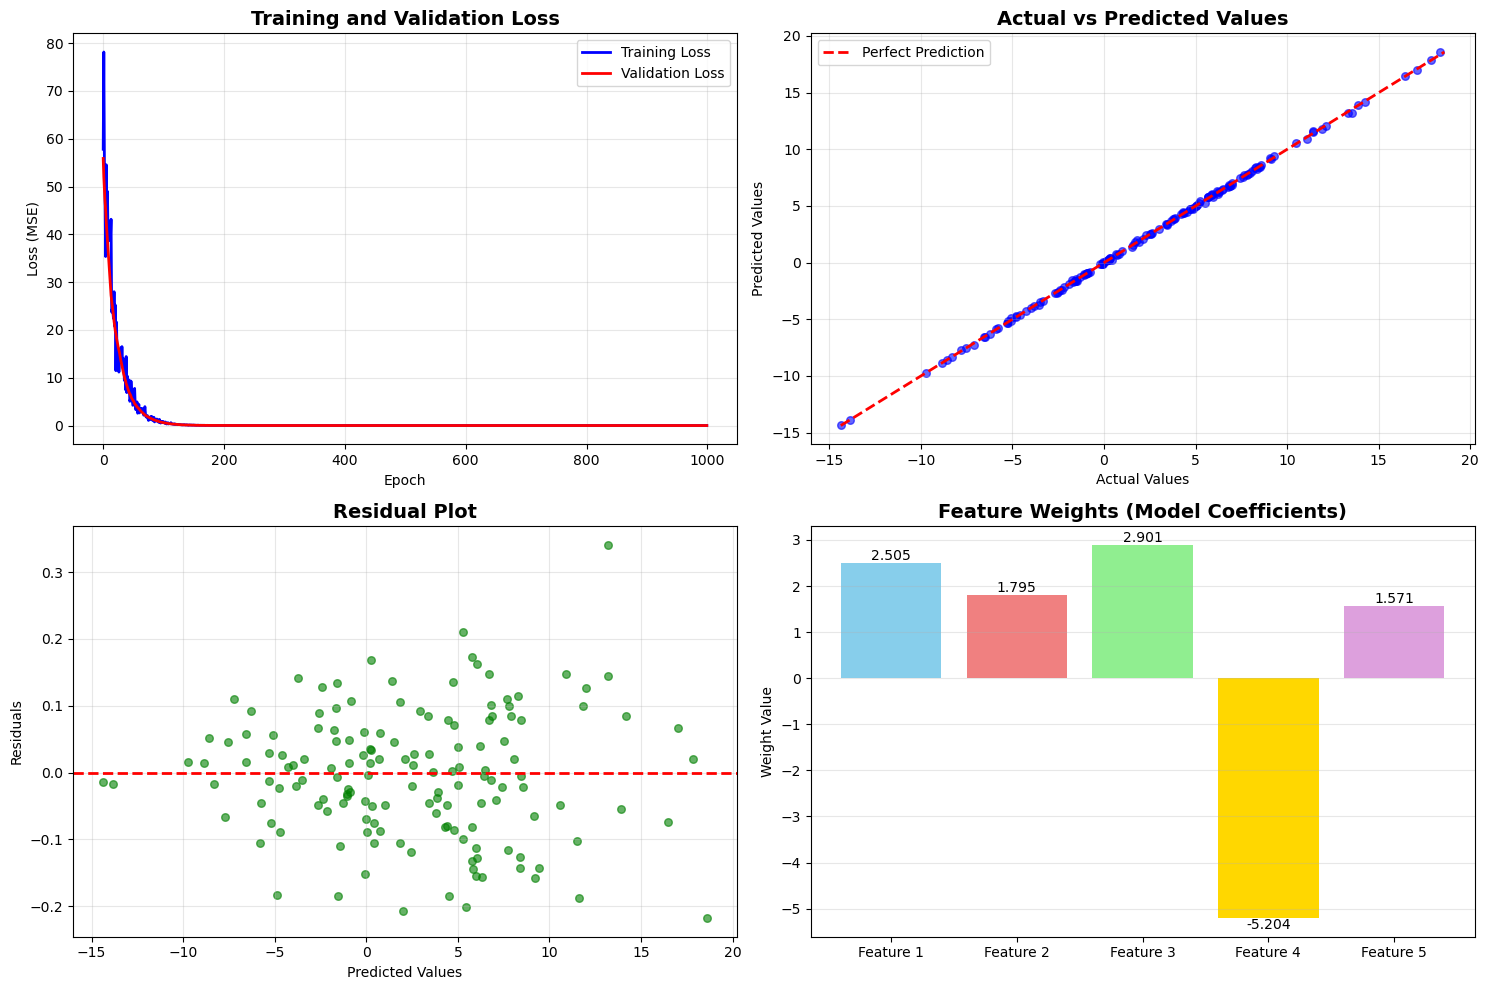


Training completed successfully!
Final R² score: 0.9998


In [12]:
# Generate plots
print("\nGenerating plots...")
plot_results(train_losses, val_losses, test_results, model)

print(f"\nTraining completed successfully!")
print(f"Final R² score: {test_results['r2']:.4f}")
